# Category LSTM

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda (Lambda)                (None, 128)          0           ['attention_mask[0][0]']         
                                                                                              

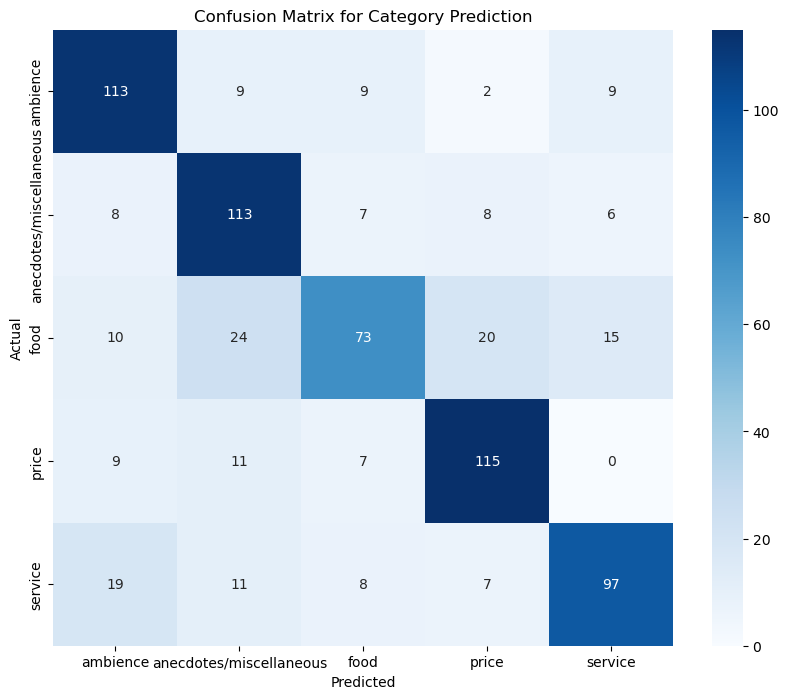

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample, class_weight
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load and preprocess the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Category']]

# Preprocessing functions
stop_words = set(stopwords.words('bengali'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# Upsampling for class balance
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Category')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode the labels
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

# Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    return tokenizer(
        df['Text'].tolist(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

tokenized = tokenize_data(df)
input_ids = tokenized['input_ids']
attention_masks = tokenized['attention_mask']

# Split the data with stratification
X_train, X_test, att_mask_train, att_mask_test, y_train, y_test = train_test_split(
    input_ids.numpy(), 
    attention_masks.numpy(),
    df['Category'].values,
    test_size=0.2, 
    random_state=42,
    stratify=df['Category']
)

# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_cat_train = to_categorical(y_train, num_classes=num_classes)
y_cat_test = to_categorical(y_test, num_classes=num_classes)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(num_classes)}

# Define the single-task LSTM model (Category Prediction)
input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Shared LSTM layers
lstm_layer = LSTM(128, return_sequences=True)(masked_embedding)
lstm_layer = LSTM(64, return_sequences=False)(lstm_layer)
batch_norm = BatchNormalization()(lstm_layer)
dropout_layer = Dropout(0.3)(batch_norm)

# Task-specific output layer for 'Category'
category_output = Dense(num_classes, activation='softmax', name='Category')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=category_output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model with callbacks
history = model.fit(
    [X_train, att_mask_train],
    y_cat_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights_dict
)

# Evaluate the model
results = model.evaluate(
    [X_test, att_mask_test],
    y_cat_test
)

print(f"Test Loss and Accuracy: {results}")

# Classification Report
predictions = model.predict([X_test, att_mask_test])
y_cat_pred = np.argmax(predictions, axis=1)

print("Classification Report for Category:")
print(classification_report(
    y_test,  # Use original labels
    y_cat_pred, 
    zero_division=0  # Handle undefined metrics
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_cat_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Category Prediction')
plt.show()


# polarity LSTM

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda_8 (Lambda)              (None, 128)          0           ['attention_mask[0][0]']         
                                                                                            

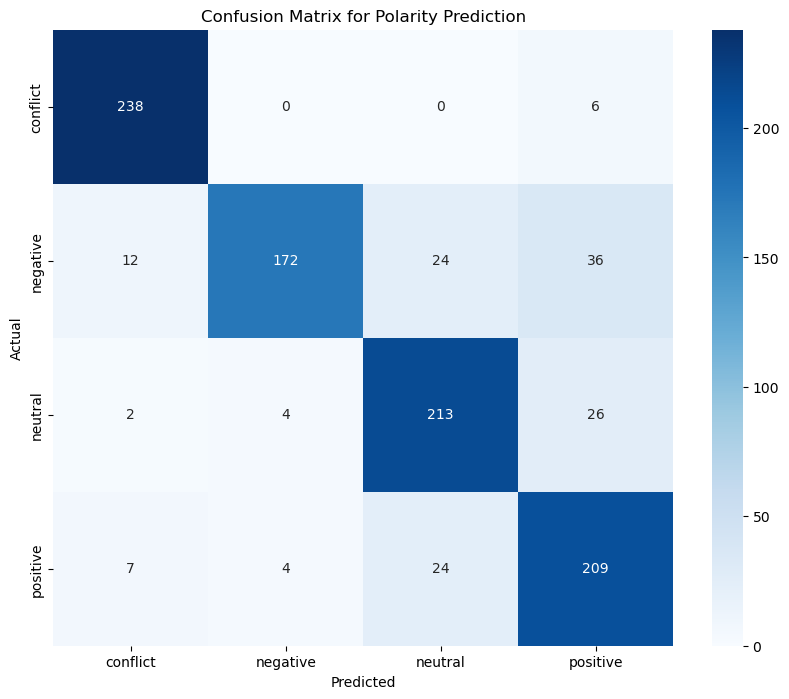

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer  # Removed due to language mismatch
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load and preprocess the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Polarity']]  # Keep only 'Text' and 'Polarity' for single-task

# Tokenize Bengali text (pre-cleaning example provided)
# Since WordNetLemmatizer is not suitable for Bengali, we'll skip lemmatization or use a simple stemmer if available
stop_words = set(stopwords.words('bengali'))

def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Removed lemmatization
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# Upsampling for class balance
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Polarity')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode the labels for Polarity
label_encoder = LabelEncoder()
df['Polarity'] = label_encoder.fit_transform(df['Polarity'])

# Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    input_ids = []
    attention_masks = []
    for sentence in df['Text']:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True, 
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    input_ids = tf.squeeze(input_ids, axis=1)
    attention_masks = tf.squeeze(attention_masks, axis=1)
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_data(df)

# Split the data
X_train, X_test, att_mask_train, att_mask_test, y_polarity_train, y_polarity_test = train_test_split(
    input_ids.numpy(), attention_masks.numpy(),
    df['Polarity'].values,
    test_size=0.2, random_state=42,
    stratify=df['Polarity']  # Ensures proportional representation
)

# One-hot encode the labels for Polarity
num_classes = len(np.unique(y_polarity_train))
y_polarity_train = to_categorical(y_polarity_train, num_classes=num_classes)
y_polarity_test = to_categorical(y_polarity_test, num_classes=num_classes)

# Compute class weights to handle any residual class imbalance
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['Polarity']),
    y=df['Polarity']
)
class_weights_dict = {i: class_weights_array[i] for i in range(num_classes)}

# Define the single-task Bidirectional LSTM model (Polarity Prediction)
input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Shared LSTM layers
lstm_layer = LSTM(128, return_sequences=True)(masked_embedding)
lstm_layer = LSTM(64, return_sequences=False)(lstm_layer)
batch_norm = BatchNormalization()(lstm_layer)
dropout_layer = Dropout(0.3)(batch_norm)


# Batch Normalization and Dropout
batch_norm = BatchNormalization()(dropout_layer)
dropout_layer = Dropout(0.3)(batch_norm)

# Task-specific output layer for 'Polarity'
polarity_output = Dense(num_classes, activation='softmax', name='Polarity')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=polarity_output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Verify the shapes of your data
print(f"X_train shape: {X_train.shape}")
print(f"att_mask_train shape: {att_mask_train.shape}")
print(f"y_polarity_train shape: {y_polarity_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"att_mask_test shape: {att_mask_test.shape}")
print(f"y_polarity_test shape: {y_polarity_test.shape}")

# Train the model with callbacks
history = model.fit(
    [X_train, att_mask_train],
    y_polarity_train,  # Correct variable name
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict  # Incorporate class weights
)

# Evaluate the model
results = model.evaluate(
    [X_test, att_mask_test],
    y_polarity_test
)

print(f"Test Loss and Accuracy: {results}")

# Classification Report
predictions = model.predict([X_test, att_mask_test])
y_polarity_pred = np.argmax(predictions, axis=1)

print("Classification Report for Polarity:")
print(classification_report(
    np.argmax(y_polarity_test, axis=1), 
    y_polarity_pred, 
    zero_division=0  # Handle undefined metrics
))

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_polarity_test, axis=1), y_polarity_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Polarity Prediction')
plt.show()


# Bidirectional LSTM polarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Label Mapping:
0: conflict
1: negative
2: neutral
3: positive


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Class Weights: {0: 0.9997441146366428, 1: 0.9997441146366428, 2: 1.0007684426229508, 3: 0.9997441146366428}
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda_2 (Lambda)              (None, 128)          0           ['attention_mask[0

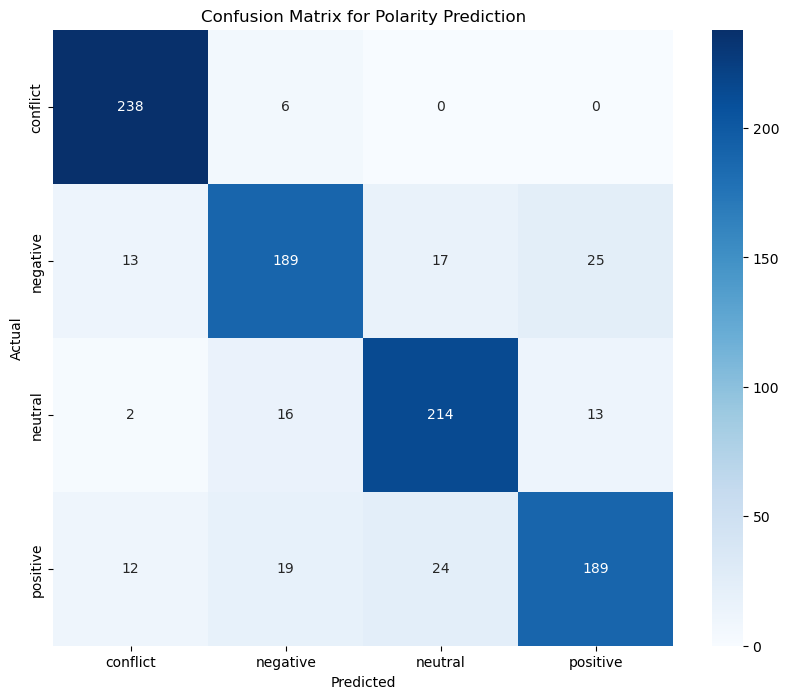

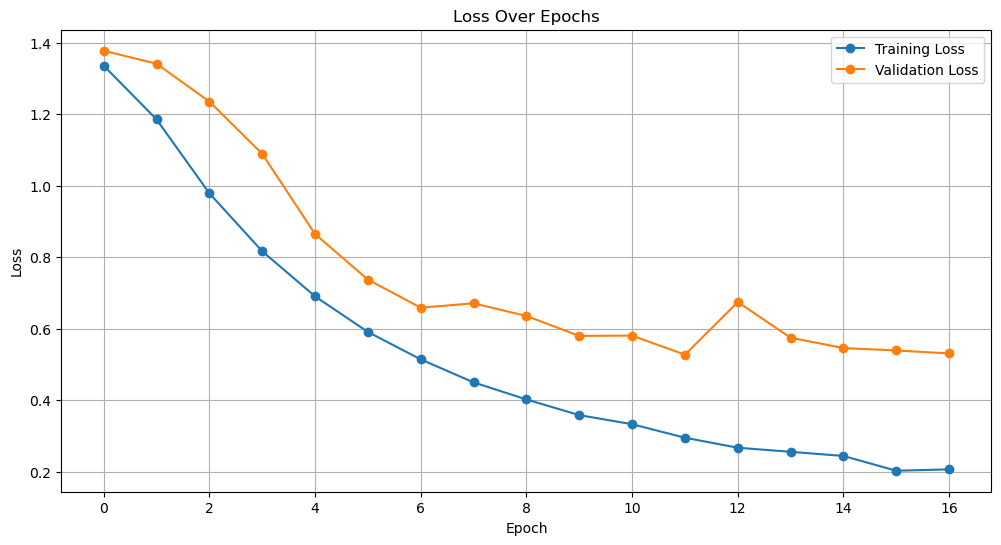

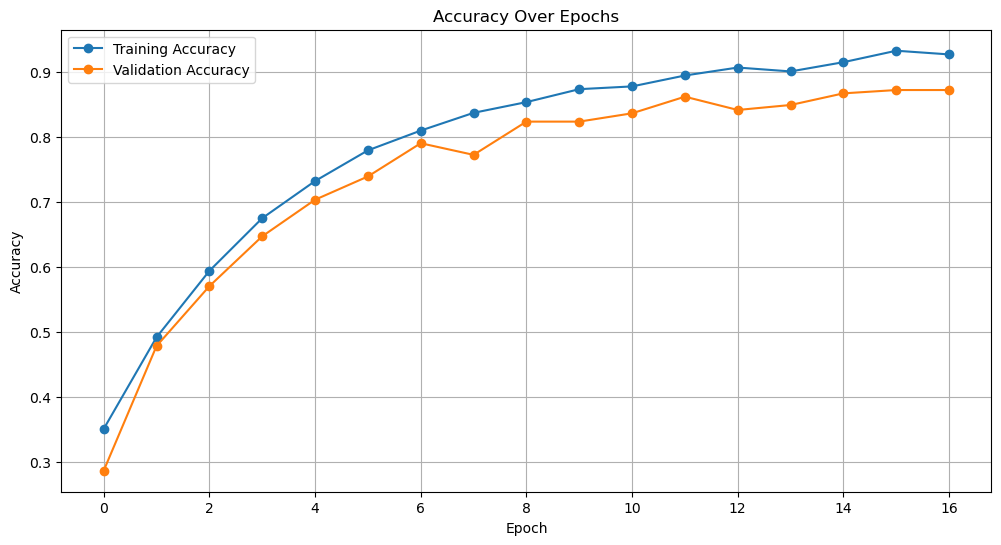

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. Download NLTK Data
# ------------------------------
nltk.download('punkt')
nltk.download('stopwords')

# ------------------------------
# 2. Load and Preprocess the Dataset
# ------------------------------
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Polarity']]  # Keep only 'Text' and 'Polarity' for single-task

# ------------------------------
# 3. Text Cleaning Function
# ------------------------------
stop_words = set(stopwords.words('bengali'))

def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Removed lemmatization
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# ------------------------------
# 4. Upsample to Balance Classes
# ------------------------------
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Polarity')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

# ------------------------------
# 5. Encode Labels
# ------------------------------
label_encoder = LabelEncoder()
df['Polarity'] = label_encoder.fit_transform(df['Polarity'])
# Optional: Print label mapping
print("Label Mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")

# ------------------------------
# 6. Tokenize Text Using BERT Tokenizer
# ------------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    input_ids = []
    attention_masks = []
    for sentence in df['Text']:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True, 
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    input_ids = tf.squeeze(input_ids, axis=1)
    attention_masks = tf.squeeze(attention_masks, axis=1)
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_data(df, max_length=128)

# ------------------------------
# 7. Split the Data
# ------------------------------
X_train, X_test, att_mask_train, att_mask_test, y_polarity_train, y_polarity_test = train_test_split(
    input_ids.numpy(), attention_masks.numpy(),
    df['Polarity'].values,
    test_size=0.2, random_state=42,
    stratify=df['Polarity']  # Ensures proportional representation
)

# ------------------------------
# 8. Compute Class Weights
# ------------------------------
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_polarity_train),
    y=y_polarity_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Class Weights:", class_weights_dict)

# ------------------------------
# 9. Define the Bidirectional LSTM Model
# ------------------------------
num_classes = len(np.unique(y_polarity_train))  # Number of classes

input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Bidirectional LSTM layers
bidirectional_lstm = Bidirectional(LSTM(128, return_sequences=True))(masked_embedding)
bidirectional_lstm = Bidirectional(LSTM(64, return_sequences=False))(bidirectional_lstm)

# Batch Normalization and Dropout
batch_norm = BatchNormalization()(bidirectional_lstm)
dropout_layer = Dropout(0.3)(batch_norm)

# Output layer for 'Polarity'
polarity_output = Dense(num_classes, activation='softmax', name='Polarity')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=polarity_output)

# ------------------------------
# 10. Compile the Model
# ------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate for faster convergence
    loss='sparse_categorical_crossentropy',  # Suitable for integer labels
    metrics=['accuracy']
)

# ------------------------------
# 11. Model Summary
# ------------------------------
model.summary()

# ------------------------------
# 12. Define Callbacks
# ------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_polarity_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ------------------------------
# 13. Verify Data Shapes
# ------------------------------
print("\n--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")                     # (num_train_samples, 128)
print(f"att_mask_train shape: {att_mask_train.shape}")       # (num_train_samples, 128)
print(f"y_polarity_train shape: {y_polarity_train.shape}")   # (num_train_samples,)

print(f"X_test shape: {X_test.shape}")                       # (num_test_samples, 128)
print(f"att_mask_test shape: {att_mask_test.shape}")         # (num_test_samples, 128)
print(f"y_polarity_test shape: {y_polarity_test.shape}")     # (num_test_samples,)
print("--------------------\n")

# ------------------------------
# 14. Train the Model
# ------------------------------
history = model.fit(
    [X_train, att_mask_train],
    y_polarity_train,  # Use integer labels
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights_dict  # Incorporate class weights
)

# ------------------------------
# 15. Evaluate the Model
# ------------------------------
results = model.evaluate(
    [X_test, att_mask_test],
    y_polarity_test
)
print(f"\nTest Loss and Accuracy: {results}")

# ------------------------------
# 16. Classification Report
# ------------------------------
predictions = model.predict([X_test, att_mask_test])
y_polarity_pred = np.argmax(predictions, axis=1)

print("\nClassification Report for Polarity:")
print(classification_report(
    y_polarity_test, 
    y_polarity_pred, 
    target_names=label_encoder.classes_,
    zero_division=0  # Handle undefined metrics gracefully
))

# ------------------------------
# 17. Confusion Matrix Visualization
# ------------------------------
cm = confusion_matrix(y_polarity_test, y_polarity_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Polarity Prediction')
plt.show()

# ------------------------------
# 18. Plot Training History
# ------------------------------
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Bidirectional LSTM category

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Label Mapping:
0: ambience
1: anecdotes/miscellaneous
2: food
3: price
4: service


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda_3 (Lambda)              (None, 128)          0           ['attention_mask[0][0]']         
                                    

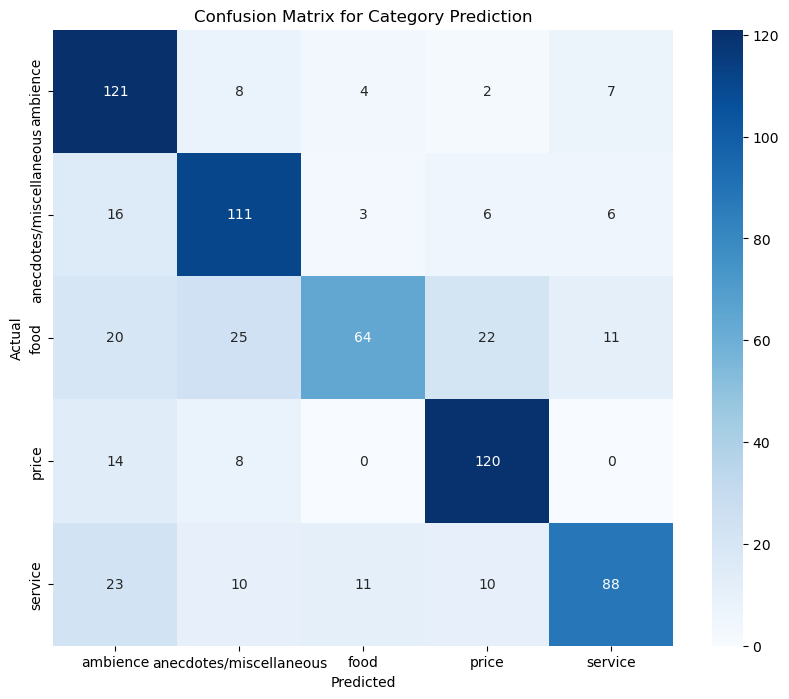

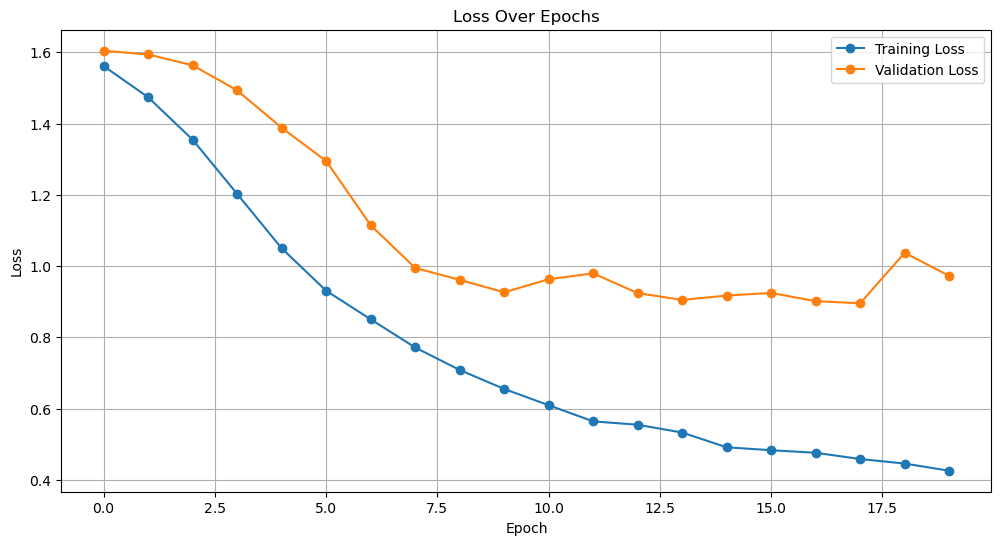

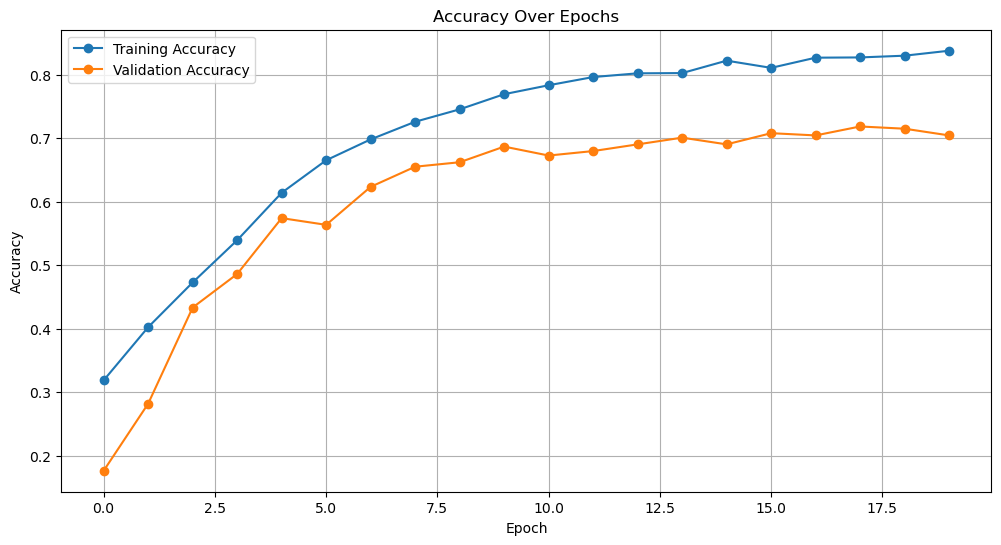

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. Download NLTK Data
# ------------------------------
nltk.download('punkt')
nltk.download('stopwords')

# ------------------------------
# 2. Load and Preprocess the Dataset
# ------------------------------
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Category']]  # Keep only 'Text' and 'Category' for single-task

# ------------------------------
# 3. Text Cleaning Function
# ------------------------------
stop_words = set(stopwords.words('bengali'))

def clean_text(text):
    """
    Cleans Bengali text by removing non-Bengali characters, numbers, extra spaces,
    and stopwords.
    """
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Removed lemmatization
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# ------------------------------
# 4. Upsample to Balance Classes
# ------------------------------
def upsample(df, target_column):
    """
    Upsamples minority classes to match the majority class count.
    """
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,       # Sample with replacement
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Category')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

# ------------------------------
# 5. Encode Labels
# ------------------------------
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

# Optional: Print label mapping
print("Label Mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")

# ------------------------------
# 6. Tokenize Text Using BERT Tokenizer
# ------------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    """
    Tokenizes the text data using BERT tokenizer and returns input IDs and attention masks.
    """
    input_ids = []
    attention_masks = []
    for sentence in df['Text']:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,          # Add [CLS] and [SEP]
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'               # Return TensorFlow tensors
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert lists to tensors and reshape
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    input_ids = tf.squeeze(input_ids, axis=1)
    attention_masks = tf.squeeze(attention_masks, axis=1)
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_data(df, max_length=128)

# ------------------------------
# 7. Split the Data
# ------------------------------
X_train, X_test, att_mask_train, att_mask_test, y_category_train, y_category_test = train_test_split(
    input_ids.numpy(), 
    attention_masks.numpy(),
    df['Category'].values,
    test_size=0.2, 
    random_state=42,
    stratify=df['Category']  # Ensures proportional representation
)

# ------------------------------
# 8. Compute Class Weights
# ------------------------------
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_category_train),
    y=y_category_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Class Weights:", class_weights_dict)

# ------------------------------
# 9. Define the Bidirectional LSTM Model (Category Prediction)
# ------------------------------
num_classes = len(np.unique(y_category_train))  # Number of classes

input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Bidirectional LSTM layers
bidirectional_lstm = Bidirectional(LSTM(128, return_sequences=True))(masked_embedding)
bidirectional_lstm = Bidirectional(LSTM(64, return_sequences=False))(bidirectional_lstm)

# Batch Normalization and Dropout
batch_norm = BatchNormalization()(bidirectional_lstm)
dropout_layer = Dropout(0.3)(batch_norm)

# Output layer for 'Category'
category_output = Dense(num_classes, activation='softmax', name='Category')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=category_output)

# ------------------------------
# 10. Compile the Model
# ------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate for faster convergence
    loss='sparse_categorical_crossentropy',  # Suitable for integer labels
    metrics=['accuracy']
)

# ------------------------------
# 11. Model Summary
# ------------------------------
model.summary()

# ------------------------------
# 12. Define Callbacks
# ------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_category_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ------------------------------
# 13. Verify Data Shapes
# ------------------------------
print("\n--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")                     # (num_train_samples, 128)
print(f"att_mask_train shape: {att_mask_train.shape}")       # (num_train_samples, 128)
print(f"y_category_train shape: {y_category_train.shape}")   # (num_train_samples,)
print(f"X_test shape: {X_test.shape}")                       # (num_test_samples, 128)
print(f"att_mask_test shape: {att_mask_test.shape}")         # (num_test_samples, 128)
print(f"y_category_test shape: {y_category_test.shape}")     # (num_test_samples,)
print("--------------------\n")

# ------------------------------
# 14. Train the Model with Callbacks
# ------------------------------
history = model.fit(
    [X_train, att_mask_train],
    y_category_train,  # Use integer labels
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights_dict  # Incorporate class weights
)

# ------------------------------
# 15. Evaluate the Model
# ------------------------------
results = model.evaluate(
    [X_test, att_mask_test],
    y_category_test
)
print(f"\nTest Loss and Accuracy: {results}")

# ------------------------------
# 16. Classification Report
# ------------------------------
predictions = model.predict([X_test, att_mask_test])
y_category_pred = np.argmax(predictions, axis=1)

print("\nClassification Report for Category:")
print(classification_report(
    y_category_test, 
    y_category_pred, 
    target_names=label_encoder.classes_,
    zero_division=0  # Handle undefined metrics gracefully
))

# ------------------------------
# 17. Confusion Matrix Visualization
# ------------------------------
cm = confusion_matrix(y_category_test, y_category_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Category Prediction')
plt.show()

# ------------------------------
# 18. Plot Training History
# ------------------------------
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# GRU for category

In [5]:
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Multiply, Lambda, BatchNormalization

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda_4 (Lambda)              (None, 128)          0           ['attention_mask[0][0]']         
                                                                                            

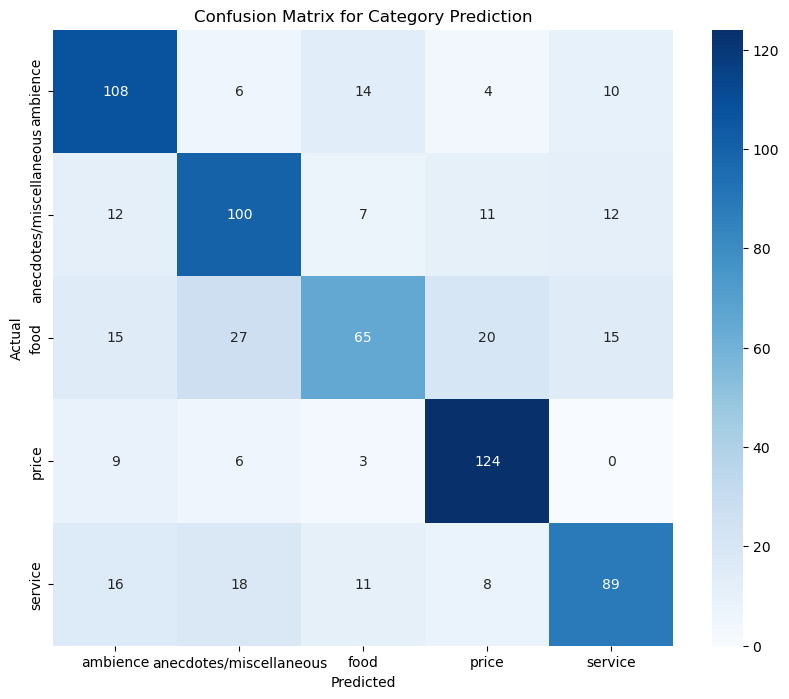

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample, class_weight
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load and preprocess the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Category']]

# Preprocessing functions
stop_words = set(stopwords.words('bengali'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# Upsampling for class balance
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Category')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode the labels
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

# Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    return tokenizer(
        df['Text'].tolist(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

tokenized = tokenize_data(df)
input_ids = tokenized['input_ids']
attention_masks = tokenized['attention_mask']

# Split the data with stratification
X_train, X_test, att_mask_train, att_mask_test, y_train, y_test = train_test_split(
    input_ids.numpy(), 
    attention_masks.numpy(),
    df['Category'].values,
    test_size=0.2, 
    random_state=42,
    stratify=df['Category']
)

# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_cat_train = to_categorical(y_train, num_classes=num_classes)
y_cat_test = to_categorical(y_test, num_classes=num_classes)

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(num_classes)}

# Define the single-task LSTM model (Category Prediction)
input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Define the single-task LSTM model (Category Prediction)
input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Shared LSTM layers
lstm_layer = GRU(128, return_sequences=True)(masked_embedding)
lstm_layer = GRU(64, return_sequences=False)(lstm_layer)
batch_norm = BatchNormalization()(lstm_layer)
dropout_layer = Dropout(0.3)(batch_norm)

# Task-specific output layer for 'Category'
category_output = Dense(num_classes, activation='softmax', name='Category')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=category_output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model with callbacks
history = model.fit(
    [X_train, att_mask_train],
    y_cat_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict
)

# Evaluate the model
results = model.evaluate(
    [X_test, att_mask_test],
    y_cat_test
)

print(f"Test Loss and Accuracy: {results}")

# Classification Report
predictions = model.predict([X_test, att_mask_test])
y_cat_pred = np.argmax(predictions, axis=1)

print("Classification Report for Category:")
print(classification_report(
    y_test,  # Use original labels
    y_cat_pred, 
    zero_division=0  # Handle undefined metrics
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_cat_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Category Prediction')
plt.show()


# Gru for polarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda_5 (Lambda)              (None, 128)          0           ['attention_mask[0][0]']         
                                                                                            

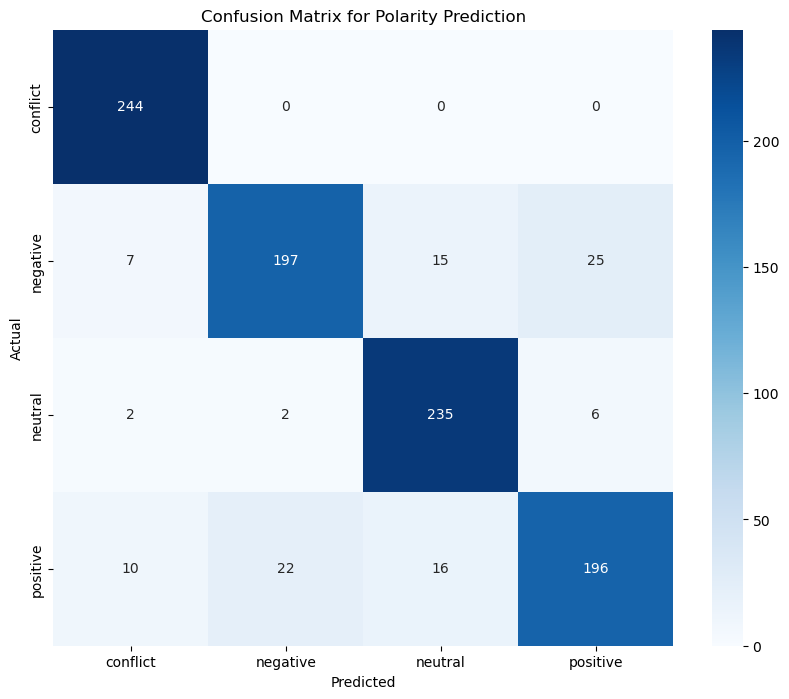

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer  # Removed due to language mismatch
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load and preprocess the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Polarity']]  # Keep only 'Text' and 'Polarity' for single-task

# Tokenize Bengali text (pre-cleaning example provided)
# Since WordNetLemmatizer is not suitable for Bengali, we'll skip lemmatization or use a simple stemmer if available
stop_words = set(stopwords.words('bengali'))

def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Removed lemmatization
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# Upsampling for class balance
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Polarity')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode the labels for Polarity
label_encoder = LabelEncoder()
df['Polarity'] = label_encoder.fit_transform(df['Polarity'])

# Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    input_ids = []
    attention_masks = []
    for sentence in df['Text']:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True, 
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    input_ids = tf.squeeze(input_ids, axis=1)
    attention_masks = tf.squeeze(attention_masks, axis=1)
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_data(df)

# Split the data
X_train, X_test, att_mask_train, att_mask_test, y_polarity_train, y_polarity_test = train_test_split(
    input_ids.numpy(), attention_masks.numpy(),
    df['Polarity'].values,
    test_size=0.2, random_state=42,
    stratify=df['Polarity']  # Ensures proportional representation
)

# One-hot encode the labels for Polarity
num_classes = len(np.unique(y_polarity_train))
y_polarity_train = to_categorical(y_polarity_train, num_classes=num_classes)
y_polarity_test = to_categorical(y_polarity_test, num_classes=num_classes)

# Compute class weights to handle any residual class imbalance
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['Polarity']),
    y=df['Polarity']
)
class_weights_dict = {i: class_weights_array[i] for i in range(num_classes)}

# Define the single-task Bidirectional LSTM model (Polarity Prediction)
input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Bidirectional LSTM layers
lstm_layer = GRU(128, return_sequences=True)(masked_embedding)
lstm_layer = GRU(64, return_sequences=False)(lstm_layer)

# Batch Normalization and Dropout
batch_norm = BatchNormalization()(lstm_layer)
dropout_layer = Dropout(0.3)(batch_norm)

# Task-specific output layer for 'Polarity'
polarity_output = Dense(num_classes, activation='softmax', name='Polarity')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=polarity_output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Verify the shapes of your data
print(f"X_train shape: {X_train.shape}")
print(f"att_mask_train shape: {att_mask_train.shape}")
print(f"y_polarity_train shape: {y_polarity_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"att_mask_test shape: {att_mask_test.shape}")
print(f"y_polarity_test shape: {y_polarity_test.shape}")

# Train the model with callbacks
history = model.fit(
    [X_train, att_mask_train],
    y_polarity_train,  # Correct variable name
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights_dict  # Incorporate class weights
)

# Evaluate the model
results = model.evaluate(
    [X_test, att_mask_test],
    y_polarity_test
)

print(f"Test Loss and Accuracy: {results}")

# Classification Report
predictions = model.predict([X_test, att_mask_test])
y_polarity_pred = np.argmax(predictions, axis=1)

print("Classification Report for Polarity:")
print(classification_report(
    np.argmax(y_polarity_test, axis=1), 
    y_polarity_pred, 
    zero_division=0  # Handle undefined metrics
))

# Confusion Matrix
cm = confusion_matrix(np.argmax(y_polarity_test, axis=1), y_polarity_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Polarity Prediction')
plt.show()


Bigru for polarity

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Label Mapping:
0: conflict
1: negative
2: neutral
3: positive


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Class Weights: {0: 0.9997441146366428, 1: 0.9997441146366428, 2: 1.0007684426229508, 3: 0.9997441146366428}
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda_6 (Lambda)              (None, 128)          0           ['attention_mask[0

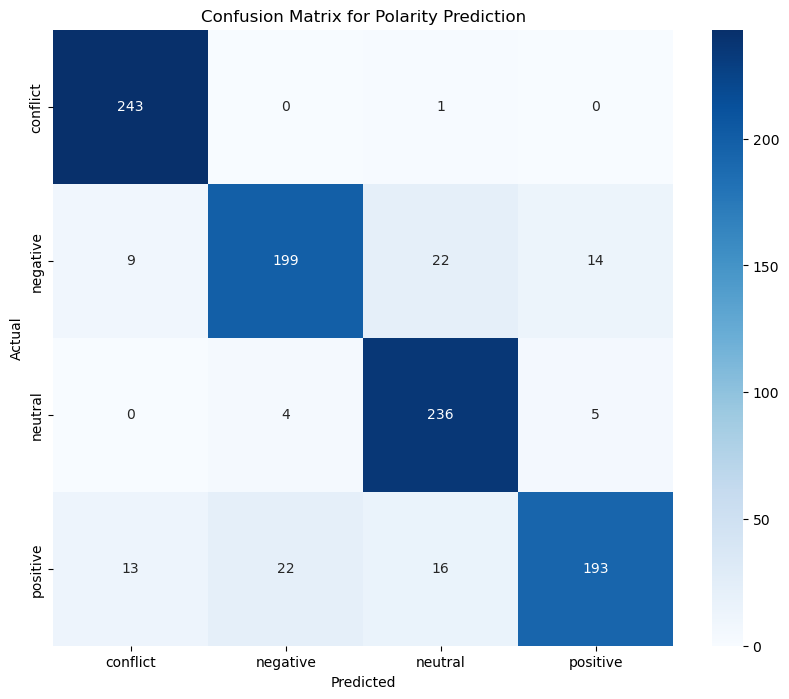

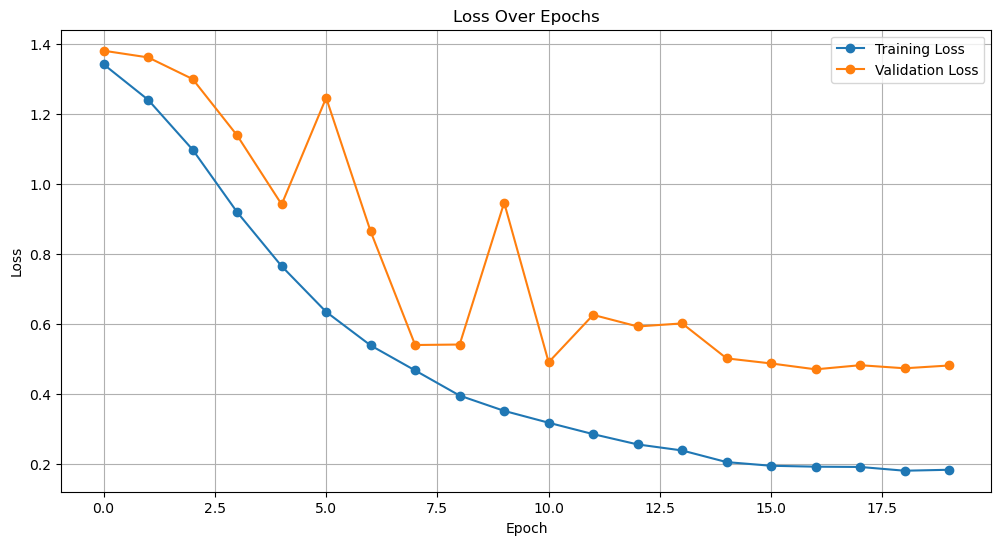

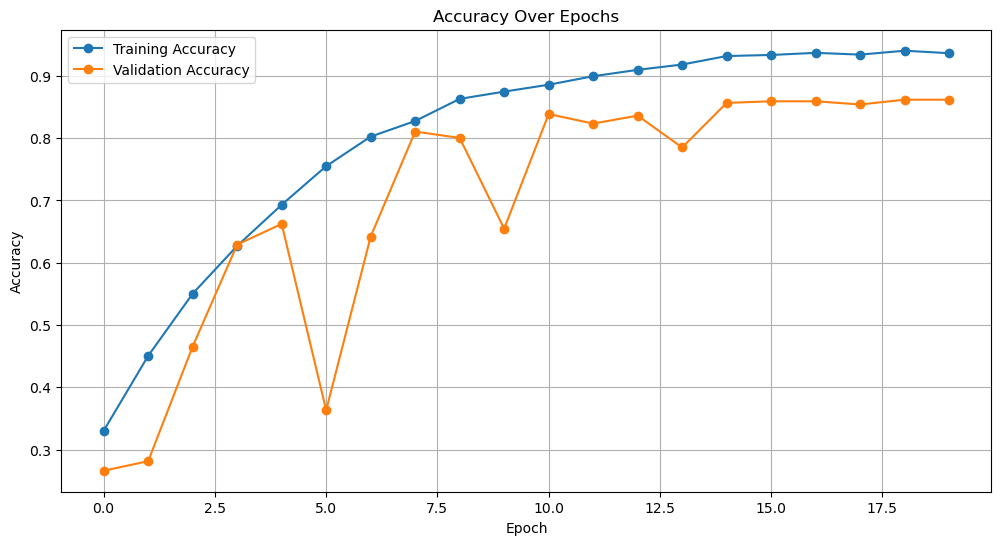

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. Download NLTK Data
# ------------------------------
nltk.download('punkt')
nltk.download('stopwords')

# ------------------------------
# 2. Load and Preprocess the Dataset
# ------------------------------
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Polarity']]  # Keep only 'Text' and 'Polarity' for single-task

# ------------------------------
# 3. Text Cleaning Function
# ------------------------------
stop_words = set(stopwords.words('bengali'))

def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Removed lemmatization
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# ------------------------------
# 4. Upsample to Balance Classes
# ------------------------------
def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Polarity')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

# ------------------------------
# 5. Encode Labels
# ------------------------------
label_encoder = LabelEncoder()
df['Polarity'] = label_encoder.fit_transform(df['Polarity'])
# Optional: Print label mapping
print("Label Mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")

# ------------------------------
# 6. Tokenize Text Using BERT Tokenizer
# ------------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    input_ids = []
    attention_masks = []
    for sentence in df['Text']:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True, 
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    input_ids = tf.squeeze(input_ids, axis=1)
    attention_masks = tf.squeeze(attention_masks, axis=1)
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_data(df, max_length=128)

# ------------------------------
# 7. Split the Data
# ------------------------------
X_train, X_test, att_mask_train, att_mask_test, y_polarity_train, y_polarity_test = train_test_split(
    input_ids.numpy(), attention_masks.numpy(),
    df['Polarity'].values,
    test_size=0.2, random_state=42,
    stratify=df['Polarity']  # Ensures proportional representation
)

# ------------------------------
# 8. Compute Class Weights
# ------------------------------
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_polarity_train),
    y=y_polarity_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Class Weights:", class_weights_dict)

# ------------------------------
# 9. Define the Bidirectional LSTM Model
# ------------------------------
num_classes = len(np.unique(y_polarity_train))  # Number of classes

input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Bidirectional LSTM layers
bidirectional_lstm = Bidirectional(GRU(128, return_sequences=True))(masked_embedding)
bidirectional_lstm = Bidirectional(GRU(64, return_sequences=False))(bidirectional_lstm)

# Batch Normalization and Dropout
batch_norm = BatchNormalization()(bidirectional_lstm)
dropout_layer = Dropout(0.3)(batch_norm)

# Output layer for 'Polarity'
polarity_output = Dense(num_classes, activation='softmax', name='Polarity')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=polarity_output)

# ------------------------------
# 10. Compile the Model
# ------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate for faster convergence
    loss='sparse_categorical_crossentropy',  # Suitable for integer labels
    metrics=['accuracy']
)

# ------------------------------
# 11. Model Summary
# ------------------------------
model.summary()

# ------------------------------
# 12. Define Callbacks
# ------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_polarity_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ------------------------------
# 13. Verify Data Shapes
# ------------------------------
print("\n--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")                     # (num_train_samples, 128)
print(f"att_mask_train shape: {att_mask_train.shape}")       # (num_train_samples, 128)
print(f"y_polarity_train shape: {y_polarity_train.shape}")   # (num_train_samples,)

print(f"X_test shape: {X_test.shape}")                       # (num_test_samples, 128)
print(f"att_mask_test shape: {att_mask_test.shape}")         # (num_test_samples, 128)
print(f"y_polarity_test shape: {y_polarity_test.shape}")     # (num_test_samples,)
print("--------------------\n")

# ------------------------------
# 14. Train the Model
# ------------------------------
history = model.fit(
    [X_train, att_mask_train],
    y_polarity_train,  # Use integer labels
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights_dict  # Incorporate class weights
)

# ------------------------------
# 15. Evaluate the Model
# ------------------------------
results = model.evaluate(
    [X_test, att_mask_test],
    y_polarity_test
)
print(f"\nTest Loss and Accuracy: {results}")

# ------------------------------
# 16. Classification Report
# ------------------------------
predictions = model.predict([X_test, att_mask_test])
y_polarity_pred = np.argmax(predictions, axis=1)

print("\nClassification Report for Polarity:")
print(classification_report(
    y_polarity_test, 
    y_polarity_pred, 
    target_names=label_encoder.classes_,
    zero_division=0  # Handle undefined metrics gracefully
))

# ------------------------------
# 17. Confusion Matrix Visualization
# ------------------------------
cm = confusion_matrix(y_polarity_test, y_polarity_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Polarity Prediction')
plt.show()

# ------------------------------
# 18. Plot Training History
# ------------------------------
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Label Mapping:
0: ambience
1: anecdotes/miscellaneous
2: food
3: price
4: service


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 128, 128)     15302016    ['input_ids[0][0]']              
                                                                                                  
 lambda_7 (Lambda)              (None, 128)          0           ['attention_mask[0][0]']         
                                    

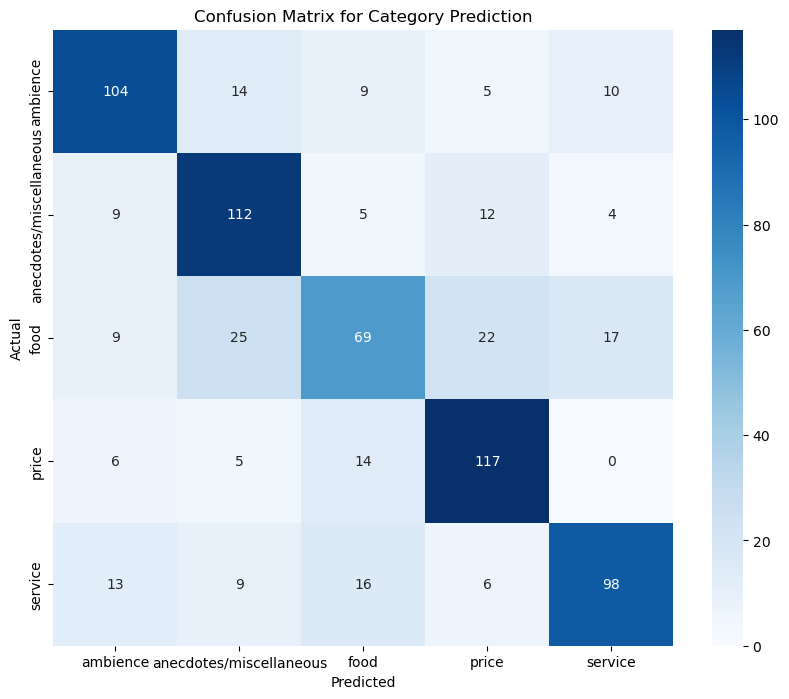

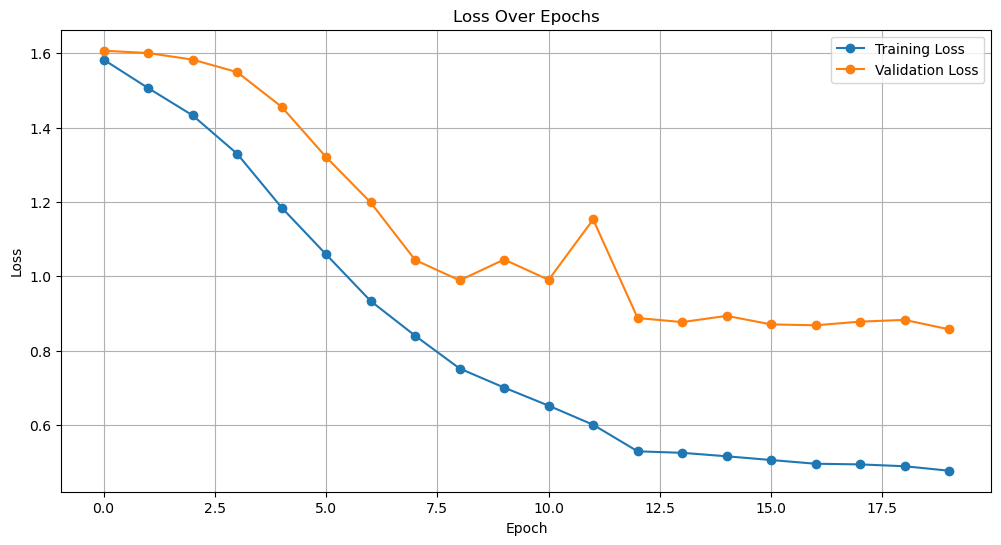

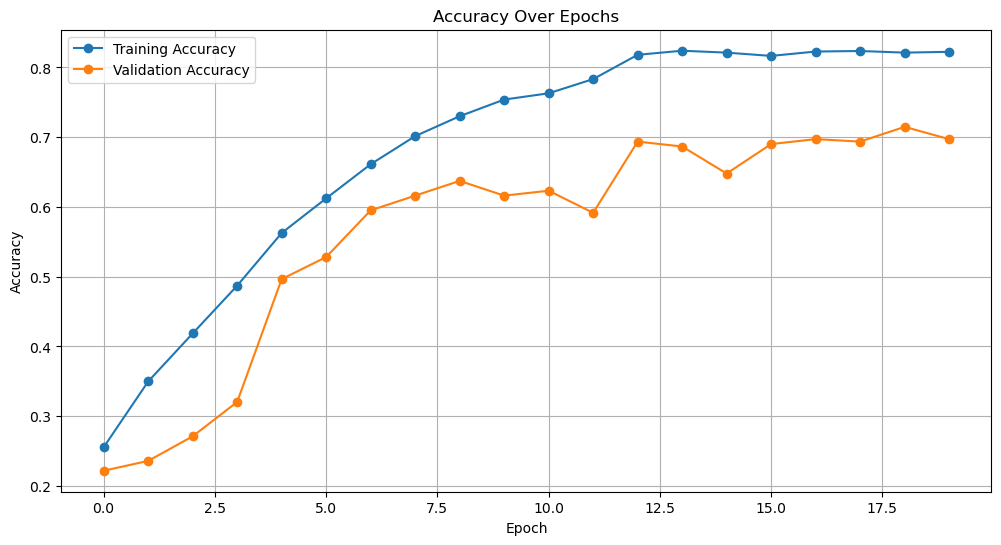

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Multiply, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from transformers import BertTokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import resample, class_weight
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1. Download NLTK Data
# ------------------------------
nltk.download('punkt')
nltk.download('stopwords')

# ------------------------------
# 2. Load and Preprocess the Dataset
# ------------------------------
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")
df = df[['Text', 'Category']]  # Keep only 'Text' and 'Category' for single-task

# ------------------------------
# 3. Text Cleaning Function
# ------------------------------
stop_words = set(stopwords.words('bengali'))

def clean_text(text):
    """
    Cleans Bengali text by removing non-Bengali characters, numbers, extra spaces,
    and stopwords.
    """
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Keep only Bengali characters
    text = re.sub(r'\d+', '', text)                 # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Removed lemmatization
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)

# ------------------------------
# 4. Upsample to Balance Classes
# ------------------------------
def upsample(df, target_column):
    """
    Upsamples minority classes to match the majority class count.
    """
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,       # Sample with replacement
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df = upsample(df, 'Category')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

# ------------------------------
# 5. Encode Labels
# ------------------------------
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

# Optional: Print label mapping
print("Label Mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")

# ------------------------------
# 6. Tokenize Text Using BERT Tokenizer
# ------------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(df, max_length=128):
    """
    Tokenizes the text data using BERT tokenizer and returns input IDs and attention masks.
    """
    input_ids = []
    attention_masks = []
    for sentence in df['Text']:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,          # Add [CLS] and [SEP]
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'               # Return TensorFlow tensors
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert lists to tensors and reshape
    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    input_ids = tf.squeeze(input_ids, axis=1)
    attention_masks = tf.squeeze(attention_masks, axis=1)
    return input_ids, attention_masks

input_ids, attention_masks = tokenize_data(df, max_length=128)

# ------------------------------
# 7. Split the Data
# ------------------------------
X_train, X_test, att_mask_train, att_mask_test, y_category_train, y_category_test = train_test_split(
    input_ids.numpy(), 
    attention_masks.numpy(),
    df['Category'].values,
    test_size=0.2, 
    random_state=42,
    stratify=df['Category']  # Ensures proportional representation
)

# ------------------------------
# 8. Compute Class Weights
# ------------------------------
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_category_train),
    y=y_category_train
)
class_weights_dict = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print("Class Weights:", class_weights_dict)

# ------------------------------
# 9. Define the Bidirectional LSTM Model (Category Prediction)
# ------------------------------
num_classes = len(np.unique(y_category_train))  # Number of classes

input_ids_layer = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype='int32', name='attention_mask')

# Embedding layer
embedding_layer = Embedding(
    input_dim=tokenizer.vocab_size, 
    output_dim=128, 
    input_length=128, 
    mask_zero=True
)(input_ids_layer)

# Apply the attention mask to the embeddings
mask_float = Lambda(lambda x: K.cast(x, dtype='float32'))(attention_mask_layer)
masked_embedding = Multiply()([embedding_layer, mask_float])

# Bidirectional LSTM layers
bidirectional_lstm = Bidirectional(GRU(128, return_sequences=True))(masked_embedding)
bidirectional_lstm = Bidirectional(GRU(64, return_sequences=False))(bidirectional_lstm)

# Batch Normalization and Dropout
batch_norm = BatchNormalization()(bidirectional_lstm)
dropout_layer = Dropout(0.3)(batch_norm)

# Output layer for 'Category'
category_output = Dense(num_classes, activation='softmax', name='Category')(dropout_layer)

# Define the model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=category_output)

# ------------------------------
# 10. Compile the Model
# ------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjusted learning rate for faster convergence
    loss='sparse_categorical_crossentropy',  # Suitable for integer labels
    metrics=['accuracy']
)

# ------------------------------
# 11. Model Summary
# ------------------------------
model.summary()

# ------------------------------
# 12. Define Callbacks
# ------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_category_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ------------------------------
# 13. Verify Data Shapes
# ------------------------------
print("\n--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")                     # (num_train_samples, 128)
print(f"att_mask_train shape: {att_mask_train.shape}")       # (num_train_samples, 128)
print(f"y_category_train shape: {y_category_train.shape}")   # (num_train_samples,)
print(f"X_test shape: {X_test.shape}")                       # (num_test_samples, 128)
print(f"att_mask_test shape: {att_mask_test.shape}")         # (num_test_samples, 128)
print(f"y_category_test shape: {y_category_test.shape}")     # (num_test_samples,)
print("--------------------\n")

# ------------------------------
# 14. Train the Model with Callbacks
# ------------------------------
history = model.fit(
    [X_train, att_mask_train],
    y_category_train,  # Use integer labels
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weights_dict  # Incorporate class weights
)

# ------------------------------
# 15. Evaluate the Model
# ------------------------------
results = model.evaluate(
    [X_test, att_mask_test],
    y_category_test
)
print(f"\nTest Loss and Accuracy: {results}")

# ------------------------------
# 16. Classification Report
# ------------------------------
predictions = model.predict([X_test, att_mask_test])
y_category_pred = np.argmax(predictions, axis=1)

print("\nClassification Report for Category:")
print(classification_report(
    y_category_test, 
    y_category_pred, 
    target_names=label_encoder.classes_,
    zero_division=0  # Handle undefined metrics gracefully
))

# ------------------------------
# 17. Confusion Matrix Visualization
# ------------------------------
cm = confusion_matrix(y_category_test, y_category_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Category Prediction')
plt.show()

# ------------------------------
# 18. Plot Training History
# ------------------------------
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
